In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

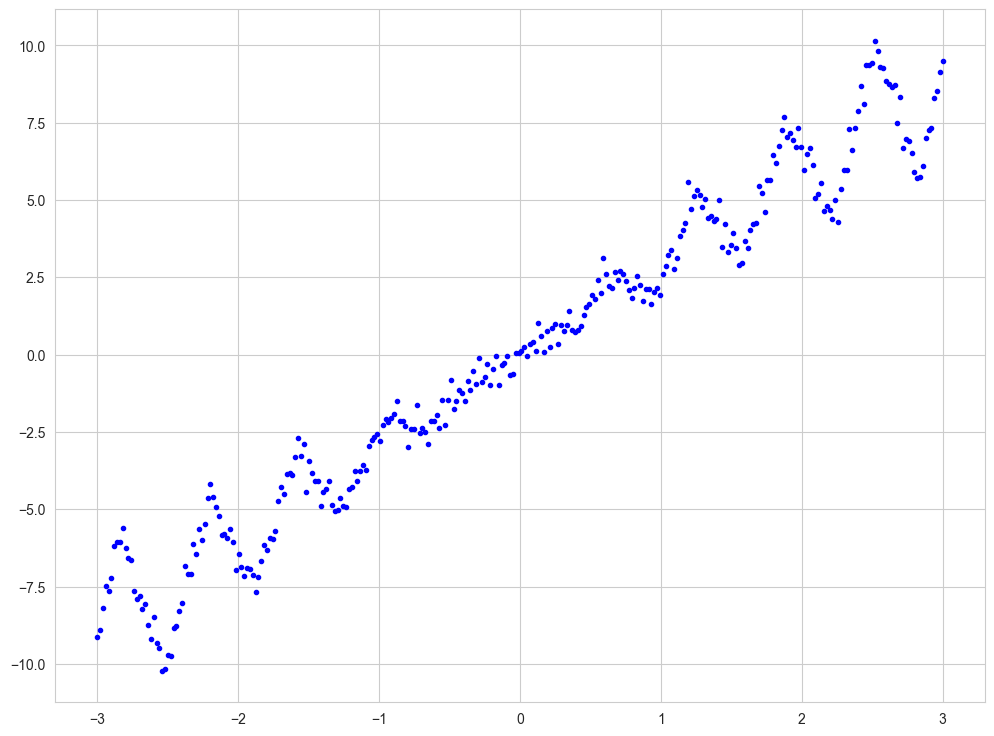

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

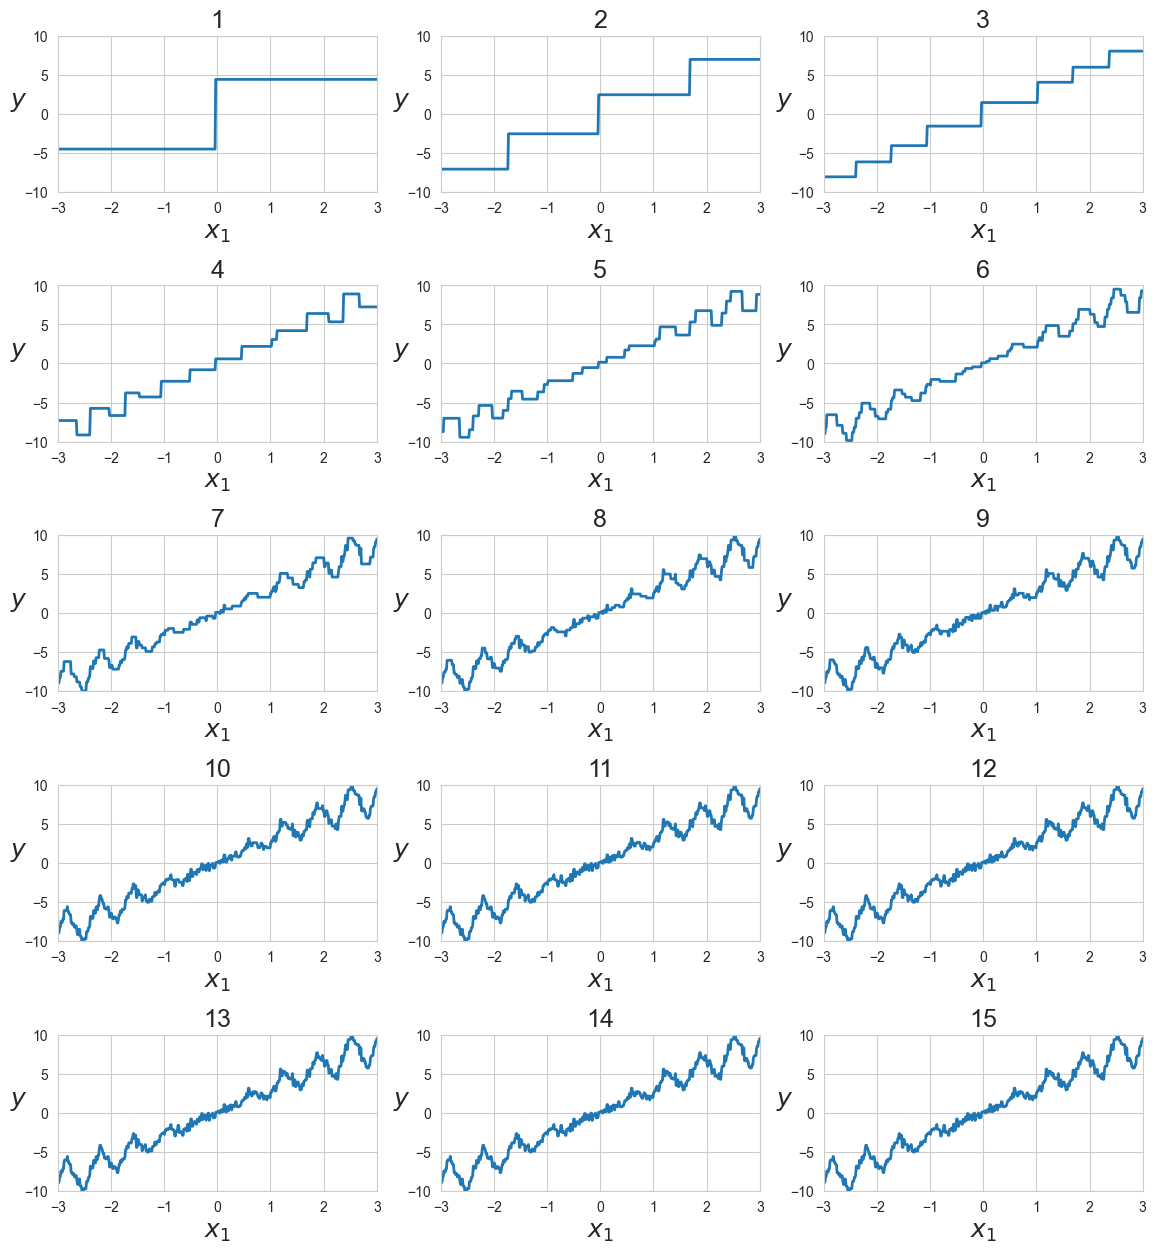

In [5]:
max_depth = range(1, 16)
scores = []
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (14,15))

for i in max_depth:
    tree_reggr = DecisionTreeRegressor(random_state=SEED, max_depth=i).fit(X, y)
    score = tree_reggr.score(X,y)
    score_data = i, score
    scores.append(score_data)

    ax1 = plt.subplot(5, 3, i)
    plot_regression_predictions(tree_reggr, X, y)
    plt.subplots_adjust(hspace=0.6)
    ax1.set_title(f'{i}', fontsize=18)

In [6]:
scores = pd.DataFrame(scores, columns=['Max_depth', 'Score'])
scores

,Max_depth,Score
0,1,0.733682
1,2,0.919261
2,3,0.967312
3,4,0.983639
4,5,0.992618
5,6,0.996036
6,7,0.998116
7,8,0.999115
8,9,0.999598
9,10,0.999869


Видим, что при глубине примерно в 7 модель начинает переобучаться.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

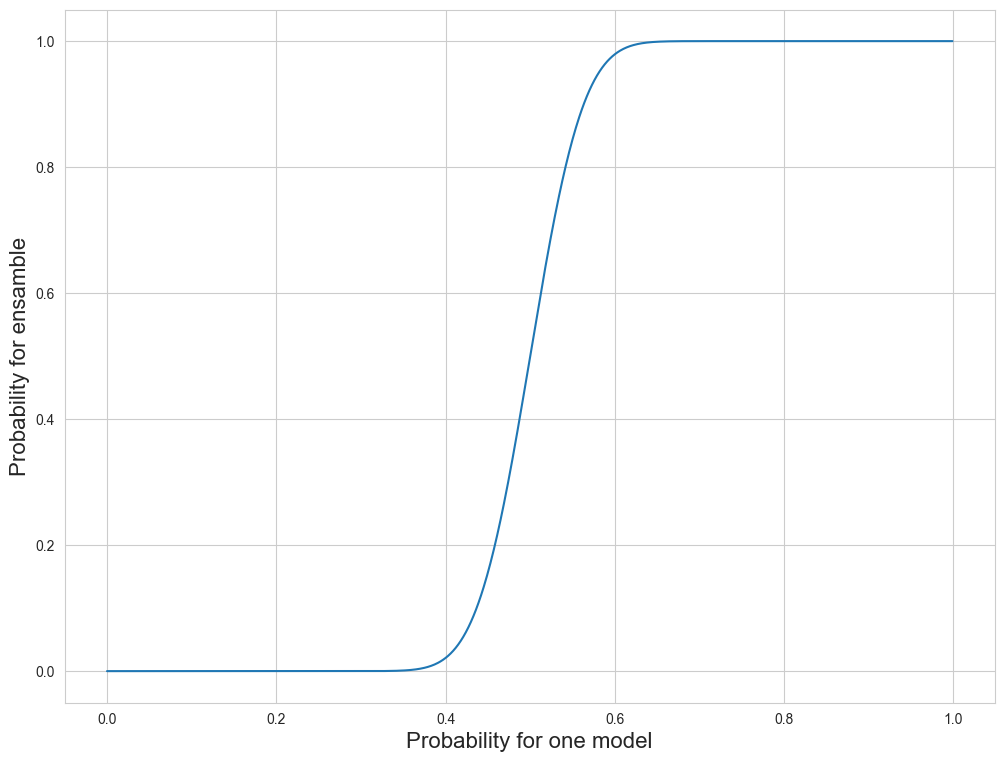

In [7]:
mu_list = []

for p in np.arange(0, 1, 0.001):
    mu = 0
    for i in range(51, 102):
        mu += (math.factorial(101)/(math.factorial(i)*math.factorial(101-i)))*(p**(i))*((1-p)**(101-i))
    mu_list.append(mu)

plt.plot(np.arange(0, 1, 0.001), mu_list)
plt.ylabel('Probability for ensamble', fontsize=16)
plt.xlabel('Probability for one model', fontsize=16)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

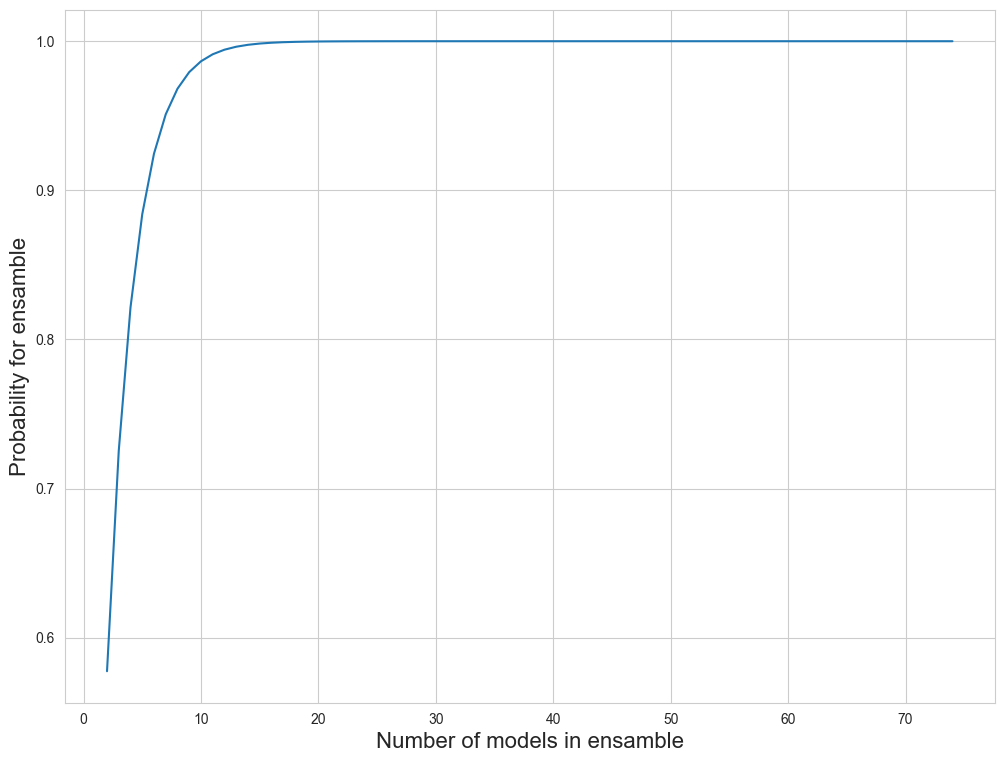

In [8]:
mu_list = []
p = 0.65
models = np.arange(2, 75, 1)

for n in models:
    mu = 0
    for k in range(n):
        mu += (math.factorial(n)/(math.factorial(k)*math.factorial(n-k))) * (p**(k)) * ((1-p)**(n-k))
    mu_list.append(mu)

plt.plot(models, mu_list)
plt.ylabel('Probability for ensamble', fontsize=16)
plt.xlabel('Number of models in ensamble', fontsize=16)
plt.show()

Опишите ваши наблюдения:

* При количестве деревьев в моделе, равном 101, модель начинает довольно точно (в более чем 80% случаев) предсказывать классы, если точность одного дерева превышает примерно 0.58%
* При фиксированной вероятности правильного предсказания, равной 0.65, достаточно около 15-ти объектов в ансамбле, чтобы предсказание было верно в около 100% случаев

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(0, self.n_estimators):

            np.random.seed(self.random_state + i)

            idx = np.random.choice(X.shape[1], size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(idx)
            pseudo_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_sample = X[pseudo_idx][:,idx]
            y_sample =y[pseudo_idx]

            tree = DecisionTreeClassifier(max_depth=self.max_depth,max_features=self.max_features, random_state=self.random_state+i)
            fitted_tree=tree.fit(X_sample, y_sample)
            self.trees.append(fitted_tree)

        return self

    def predict_proba(self, X):
        y_pred = np.zeros((X.shape[0], len(self.classes_)))

        for tree, feat in zip(self.trees, self.feat_ids_by_tree):
            y_pred += tree.predict_proba(X[:,feat])
        return y_pred
            
        return np.average(y_pred, axis = 0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

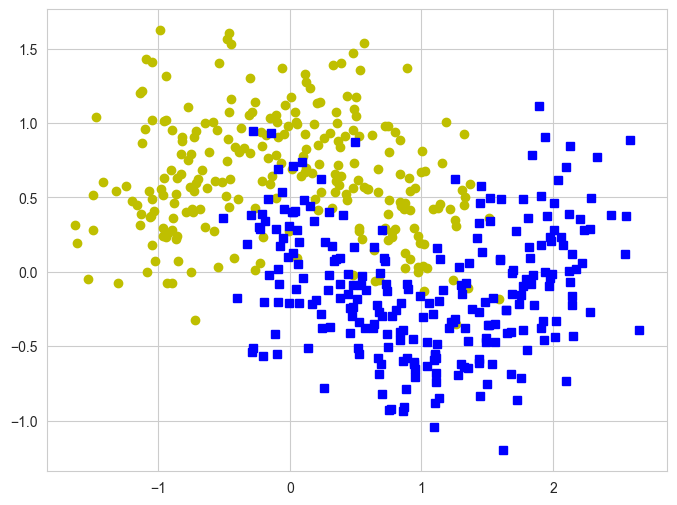

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

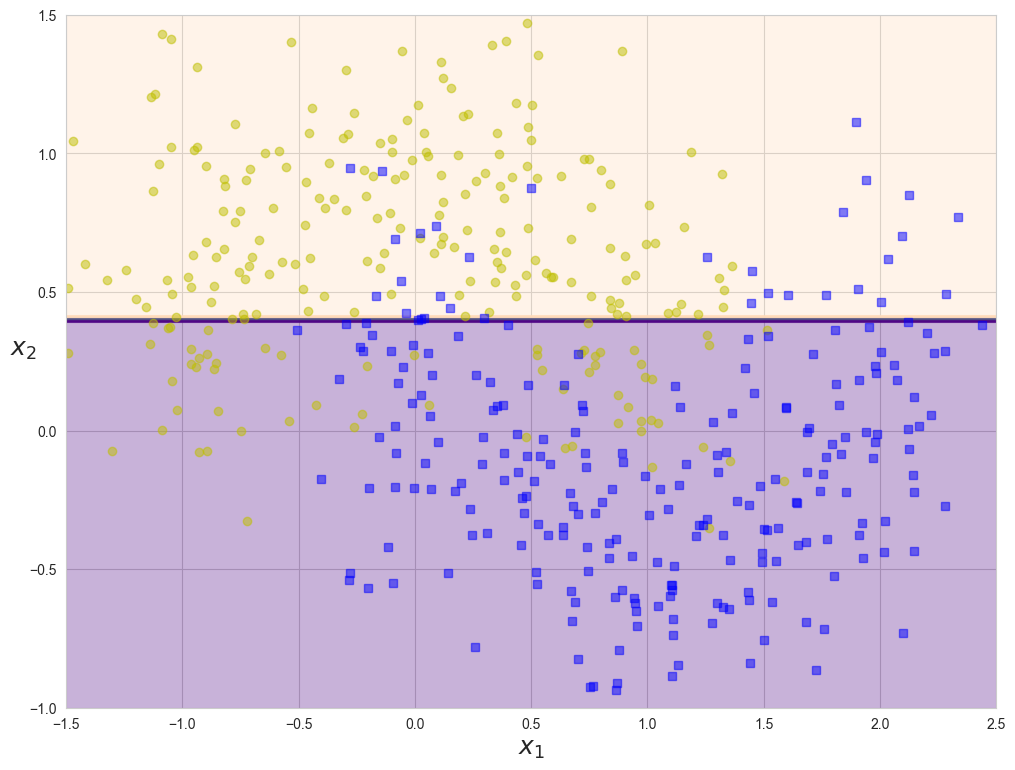

In [12]:
forest = RandomForestClassifierCustom(n_estimators=10, max_depth=1, max_features=2)
forest.fit(X,y)
plot_decision_boundary(forest, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

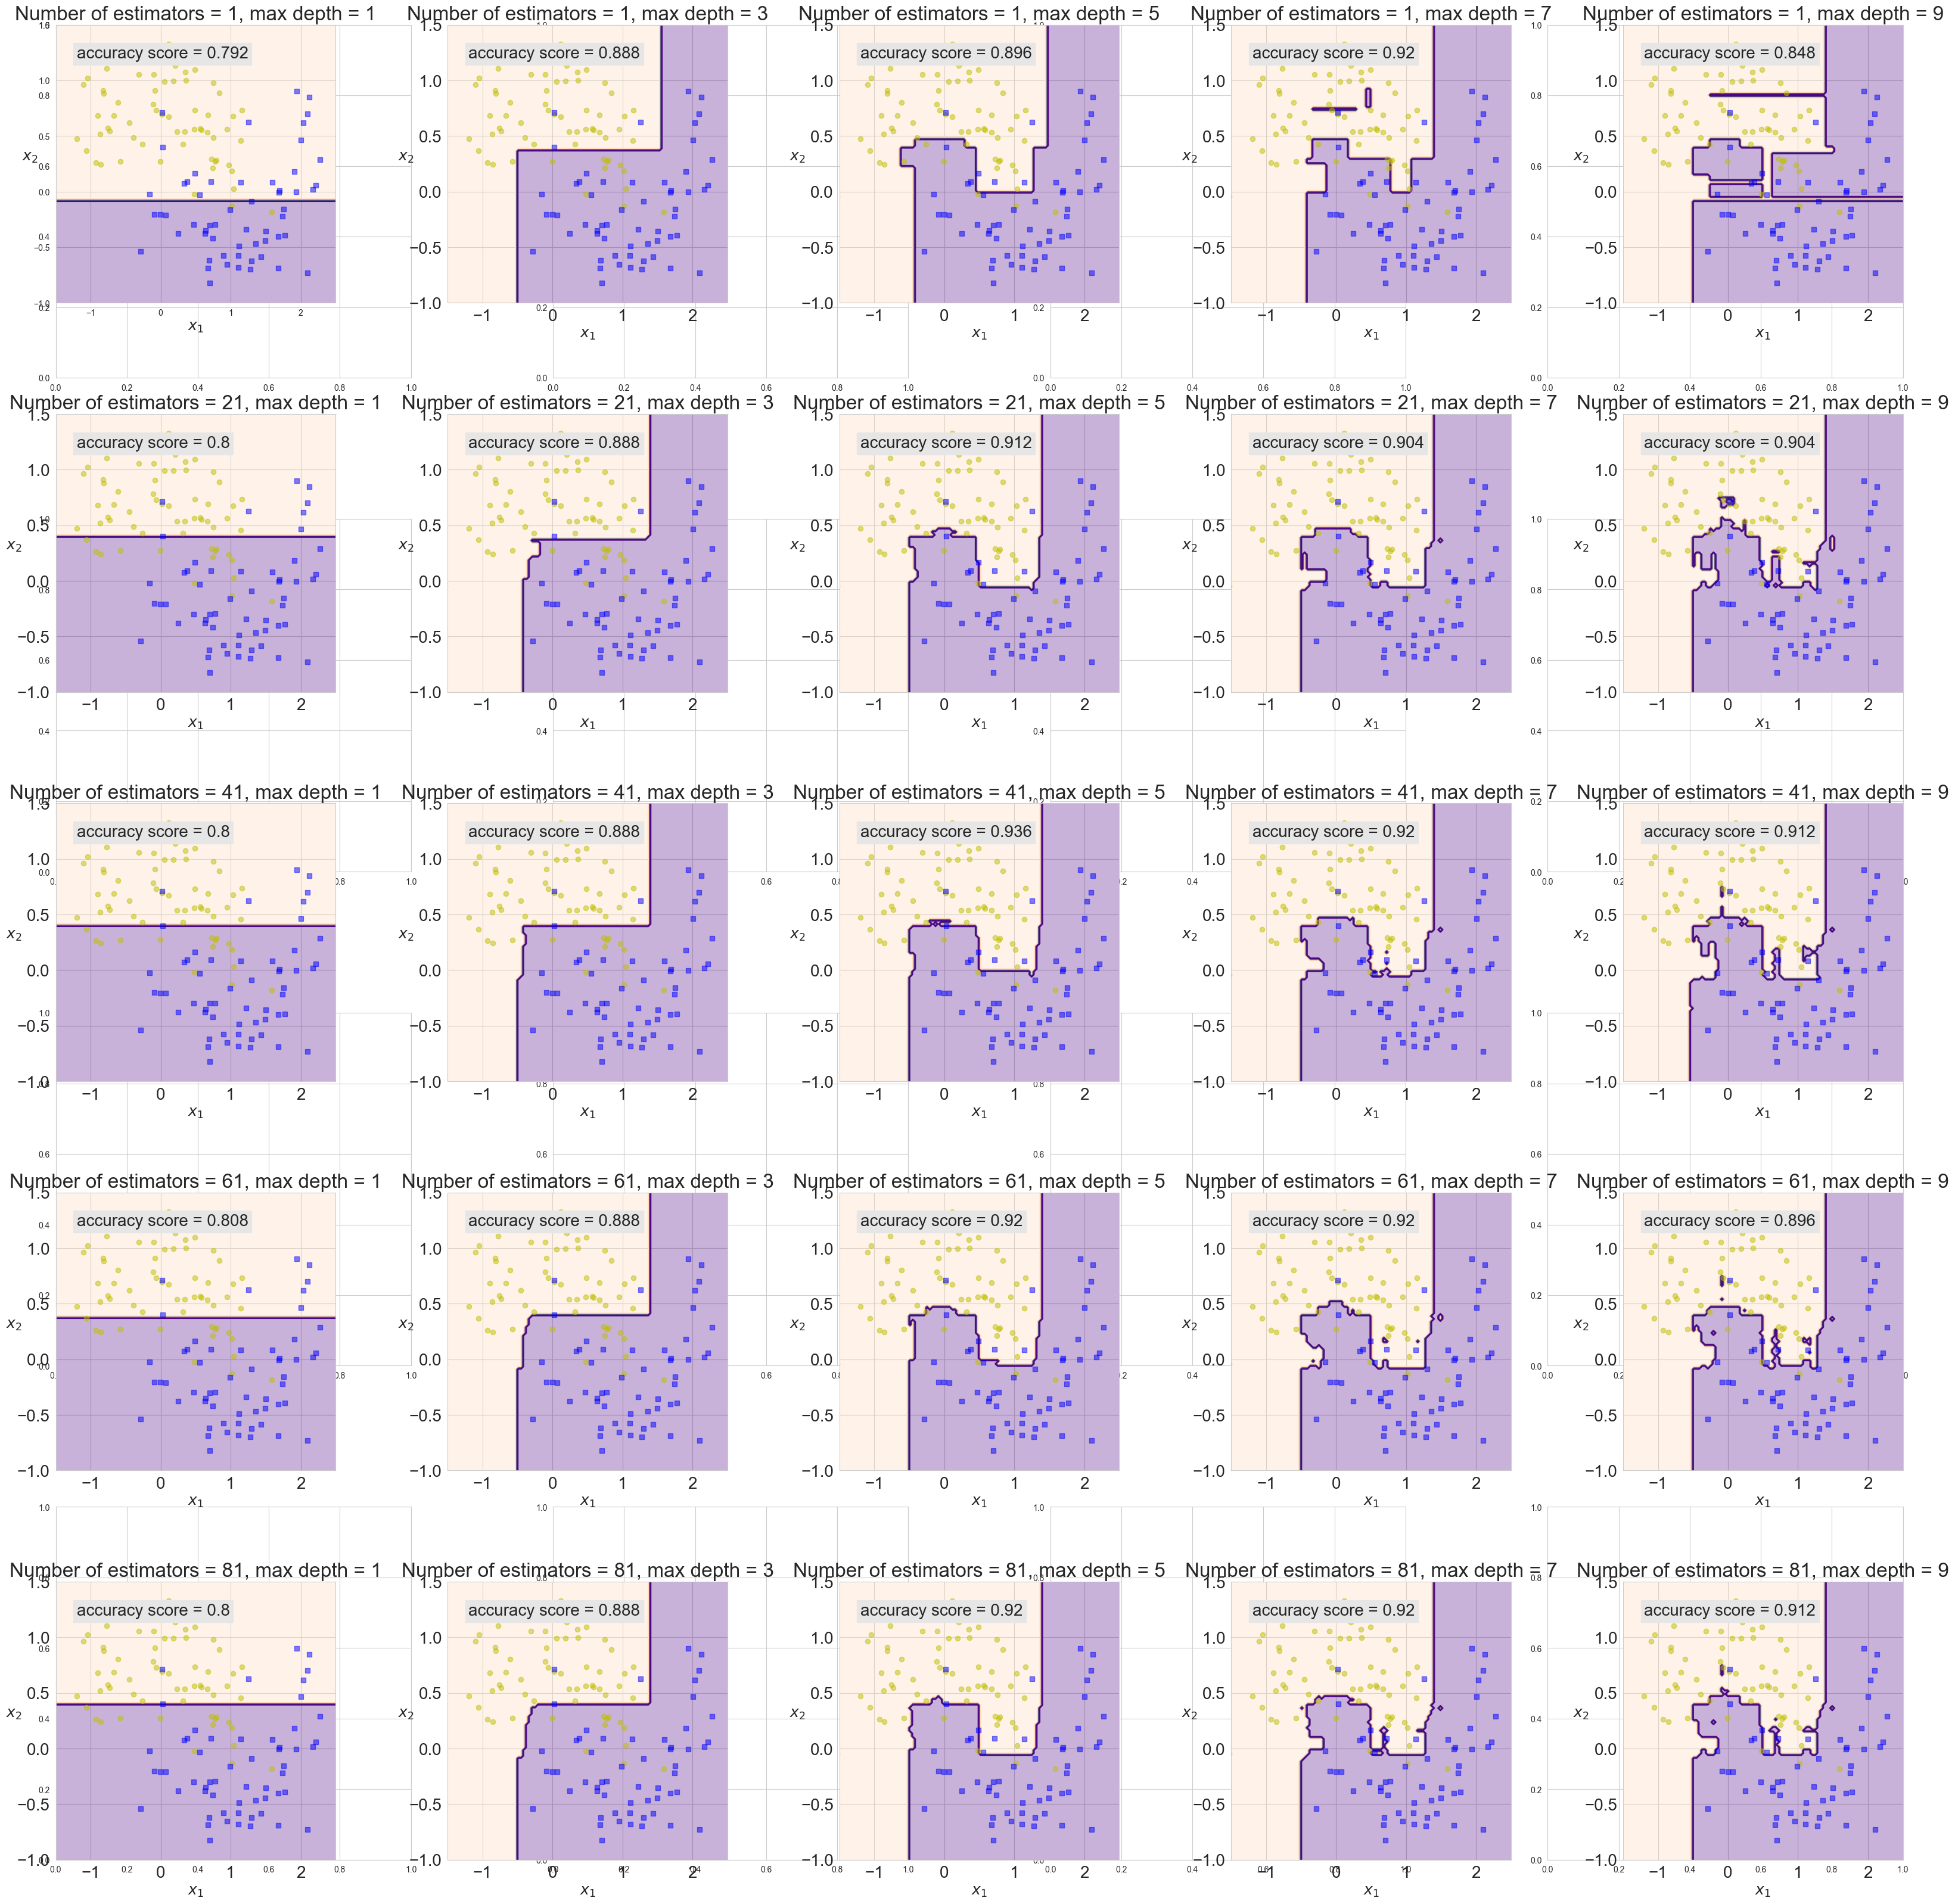

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(40,40))
counter = 1

for n in range(1, 101, 20):
    for depth in range(1, 10, 2):
        random_forest = RandomForestClassifier(n_estimators=n,max_depth=depth, max_features=2)

        random_forest.fit(X_train, y_train)
        y_pred = random_forest.predict(X_test)
        plt.subplot(5,5, counter)
        plot_decision_boundary(random_forest, X_test, y_test)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.rcParams.update({'font.size':20})
        plt.title(f'Number of estimators = {n}, max depth = {depth}')
        plt.text(-1.2, 1.2, f'accuracy score = {accuracy_score(y_test, y_pred)}', backgroundcolor='0.9', size=20)
        counter += 1

На мой взгляд, наиболее оптимальный параметры: max_depth = 5, n_estimators = 81. 
Именно при этих параметрах поле наиболее четко очерчивает синие точки, но при этом не происходит переобучения.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [15]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [16]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
max_feat = range(1, 31, 2)
corr = []

for feat in max_feat:
    forest = RandomForestClassifier(max_features=feat)
    forest.fit(X_train, y_train)
    corr_pair = base_model_pair_correlation(forest, X_test)
    corr.append(corr_pair)

corr_df = pd.DataFrame(np.array(corr).T, columns=max_feat)


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: array-like or scalar or None
  animated: bool
  antialiased or aa or antialiaseds: bool or list of bools
  array: array-like or None
  capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  clim: (vmin: float, vmax: float)
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  cmap: `.Colormap` or str or None
  color: color or list of RGBA tuples
  edgecolor or ec or edgecolors: color or list of colors or 'face'
  facecolor or facecolors or fc: color or list of colors
  figure: `~matplotlib.figure.Figure`
  gid: str
  hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
  in_layout: bool
  joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  label: object
  linestyle or dashes or linestyles or ls: str or tuple or list thereof
  l

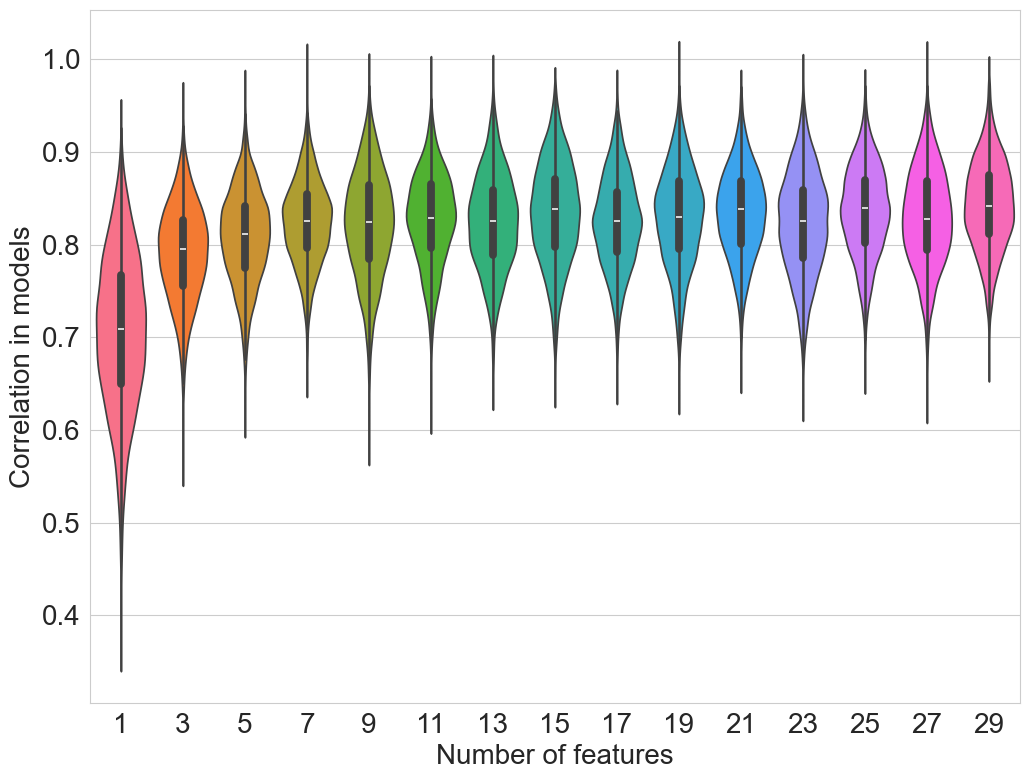

In [18]:
ax = sns.violinplot(corr_df, saturation=1)
plt.setp(ax.collections)
plt.xlabel('Number of features', fontsize=20)
plt.ylabel('Correlation in models', fontsize=20)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [19]:
max_depth = range(1, 16, 2)
corr_depth = []

for depth in max_depth:
    forest_depth = RandomForestClassifier(max_depth=depth)
    forest_depth.fit(X_train, y_train)
    corr_pair = base_model_pair_correlation(forest_depth, X_test)
    corr_depth.append(corr_pair)

corr_df_depth = pd.DataFrame(np.array(corr_depth).T, columns=max_depth)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: array-like or scalar or None
  animated: bool
  antialiased or aa or antialiaseds: bool or list of bools
  array: array-like or None
  capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  clim: (vmin: float, vmax: float)
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  cmap: `.Colormap` or str or None
  color: color or list of RGBA tuples
  edgecolor or ec or edgecolors: color or list of colors or 'face'
  facecolor or facecolors or fc: color or list of colors
  figure: `~matplotlib.figure.Figure`
  gid: str
  hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
  in_layout: bool
  joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  label: object
  linestyle or dashes or linestyles or ls: str or tuple or list thereof
  l

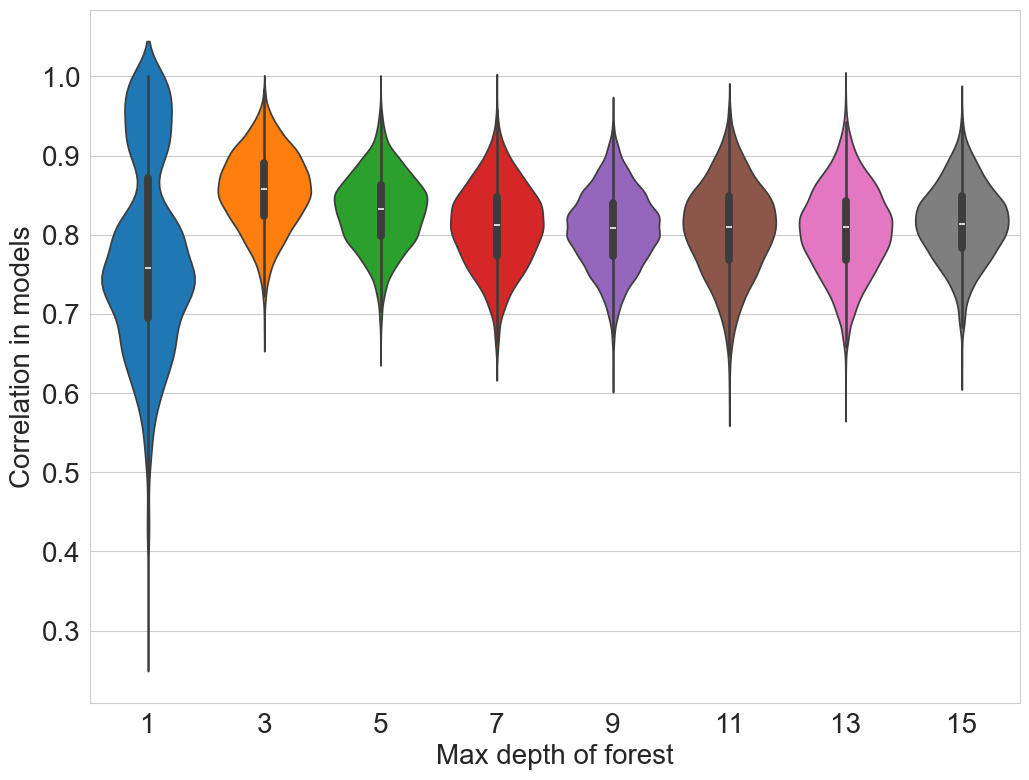

In [20]:
ax = sns.violinplot(corr_df_depth, saturation=1)
plt.setp(ax.collections)
plt.xlabel('Max depth of forest', fontsize=20)
plt.ylabel('Correlation in models', fontsize=20)
plt.show()

Опишите ваши наблюдения:

* При увеличении количества признаков корреляция растет, затем (при значении >7) выходит на плато высокой корреляции (~0.9)
* При увеличении максимальной глубины корреляция медленно снижается.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [21]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [22]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [23]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [24]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219


RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [25]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [98]:
soft = VotingClassifier(estimators=base_models, voting='soft')
soft.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(soft, X_test)

[LightGBM] [Info] Number of positive: 324, number of negative: 1909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 2233, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145096 -> initscore=-1.773591
[LightGBM] [Info] Start training from score -1.773591
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 324, number of negativ

In [102]:
for forest in corrs:
  if forest[2] > 0.92:
    print(f'{forest[0].__class__.__name__},{forest[1].__class__.__name__}, corr:{forest[2]}')

DecisionTreeClassifier,XGBRFClassifier, corr:0.9263013914427664
RandomForestClassifier,CatBoostClassifier, corr:0.9428259204302664
RandomForestClassifier,LGBMClassifier, corr:0.9222870227230916
RandomForestClassifier,XGBRFClassifier, corr:0.9284249918707838
CatBoostClassifier,LGBMClassifier, corr:0.9772922888691101
CatBoostClassifier,LGBMClassifier, corr:0.931270415863125
CatBoostClassifier,XGBClassifier, corr:0.9675722588211807
CatBoostClassifier,XGBRFClassifier, corr:0.9461520905879771
LGBMClassifier,XGBClassifier, corr:0.9682393939237224
LGBMClassifier,XGBRFClassifier, corr:0.9293330899941588
LGBMClassifier,XGBRFClassifier, corr:0.9726630479857912
XGBClassifier,XGBRFClassifier, corr:0.9360825666981131


In [103]:
adjusted_models = [("ETC", etc), ("KNN", knn), 
                   ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
                   ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), 
                   ("LR", lr), ("NB", nb)]

In [104]:
soft_adj = VotingClassifier(estimators=adjusted_models, voting='soft')
soft_adj.fit(X_train, y_train)
f1_score(y_test, soft_adj.predict(X_test))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 324, number of negative: 1909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 2233, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145096 -> initscore=-1.773591
[LightGBM] [Info] Start training from score -1.773591
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=

0.6386554621848739

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [51]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [52]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [54]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

Пропущенных значений нет, но некоторые колонки необходимо переименовать.

In [55]:
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("?", "")
data.columns = data.columns.str.replace("'", "")
data.head()

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [56]:
print(data["Churn"].value_counts())

Churn
False.    2850
True.      483
Name: count, dtype: int64


Видим, что баланс типов таргета нарушен, а классы требуют переименования. 

In [57]:
data.Churn.replace({'False.': 0, 'True.': 1}, inplace=True)
print(data["Churn"].value_counts())

Churn
0    2850
1     483
Name: count, dtype: int64


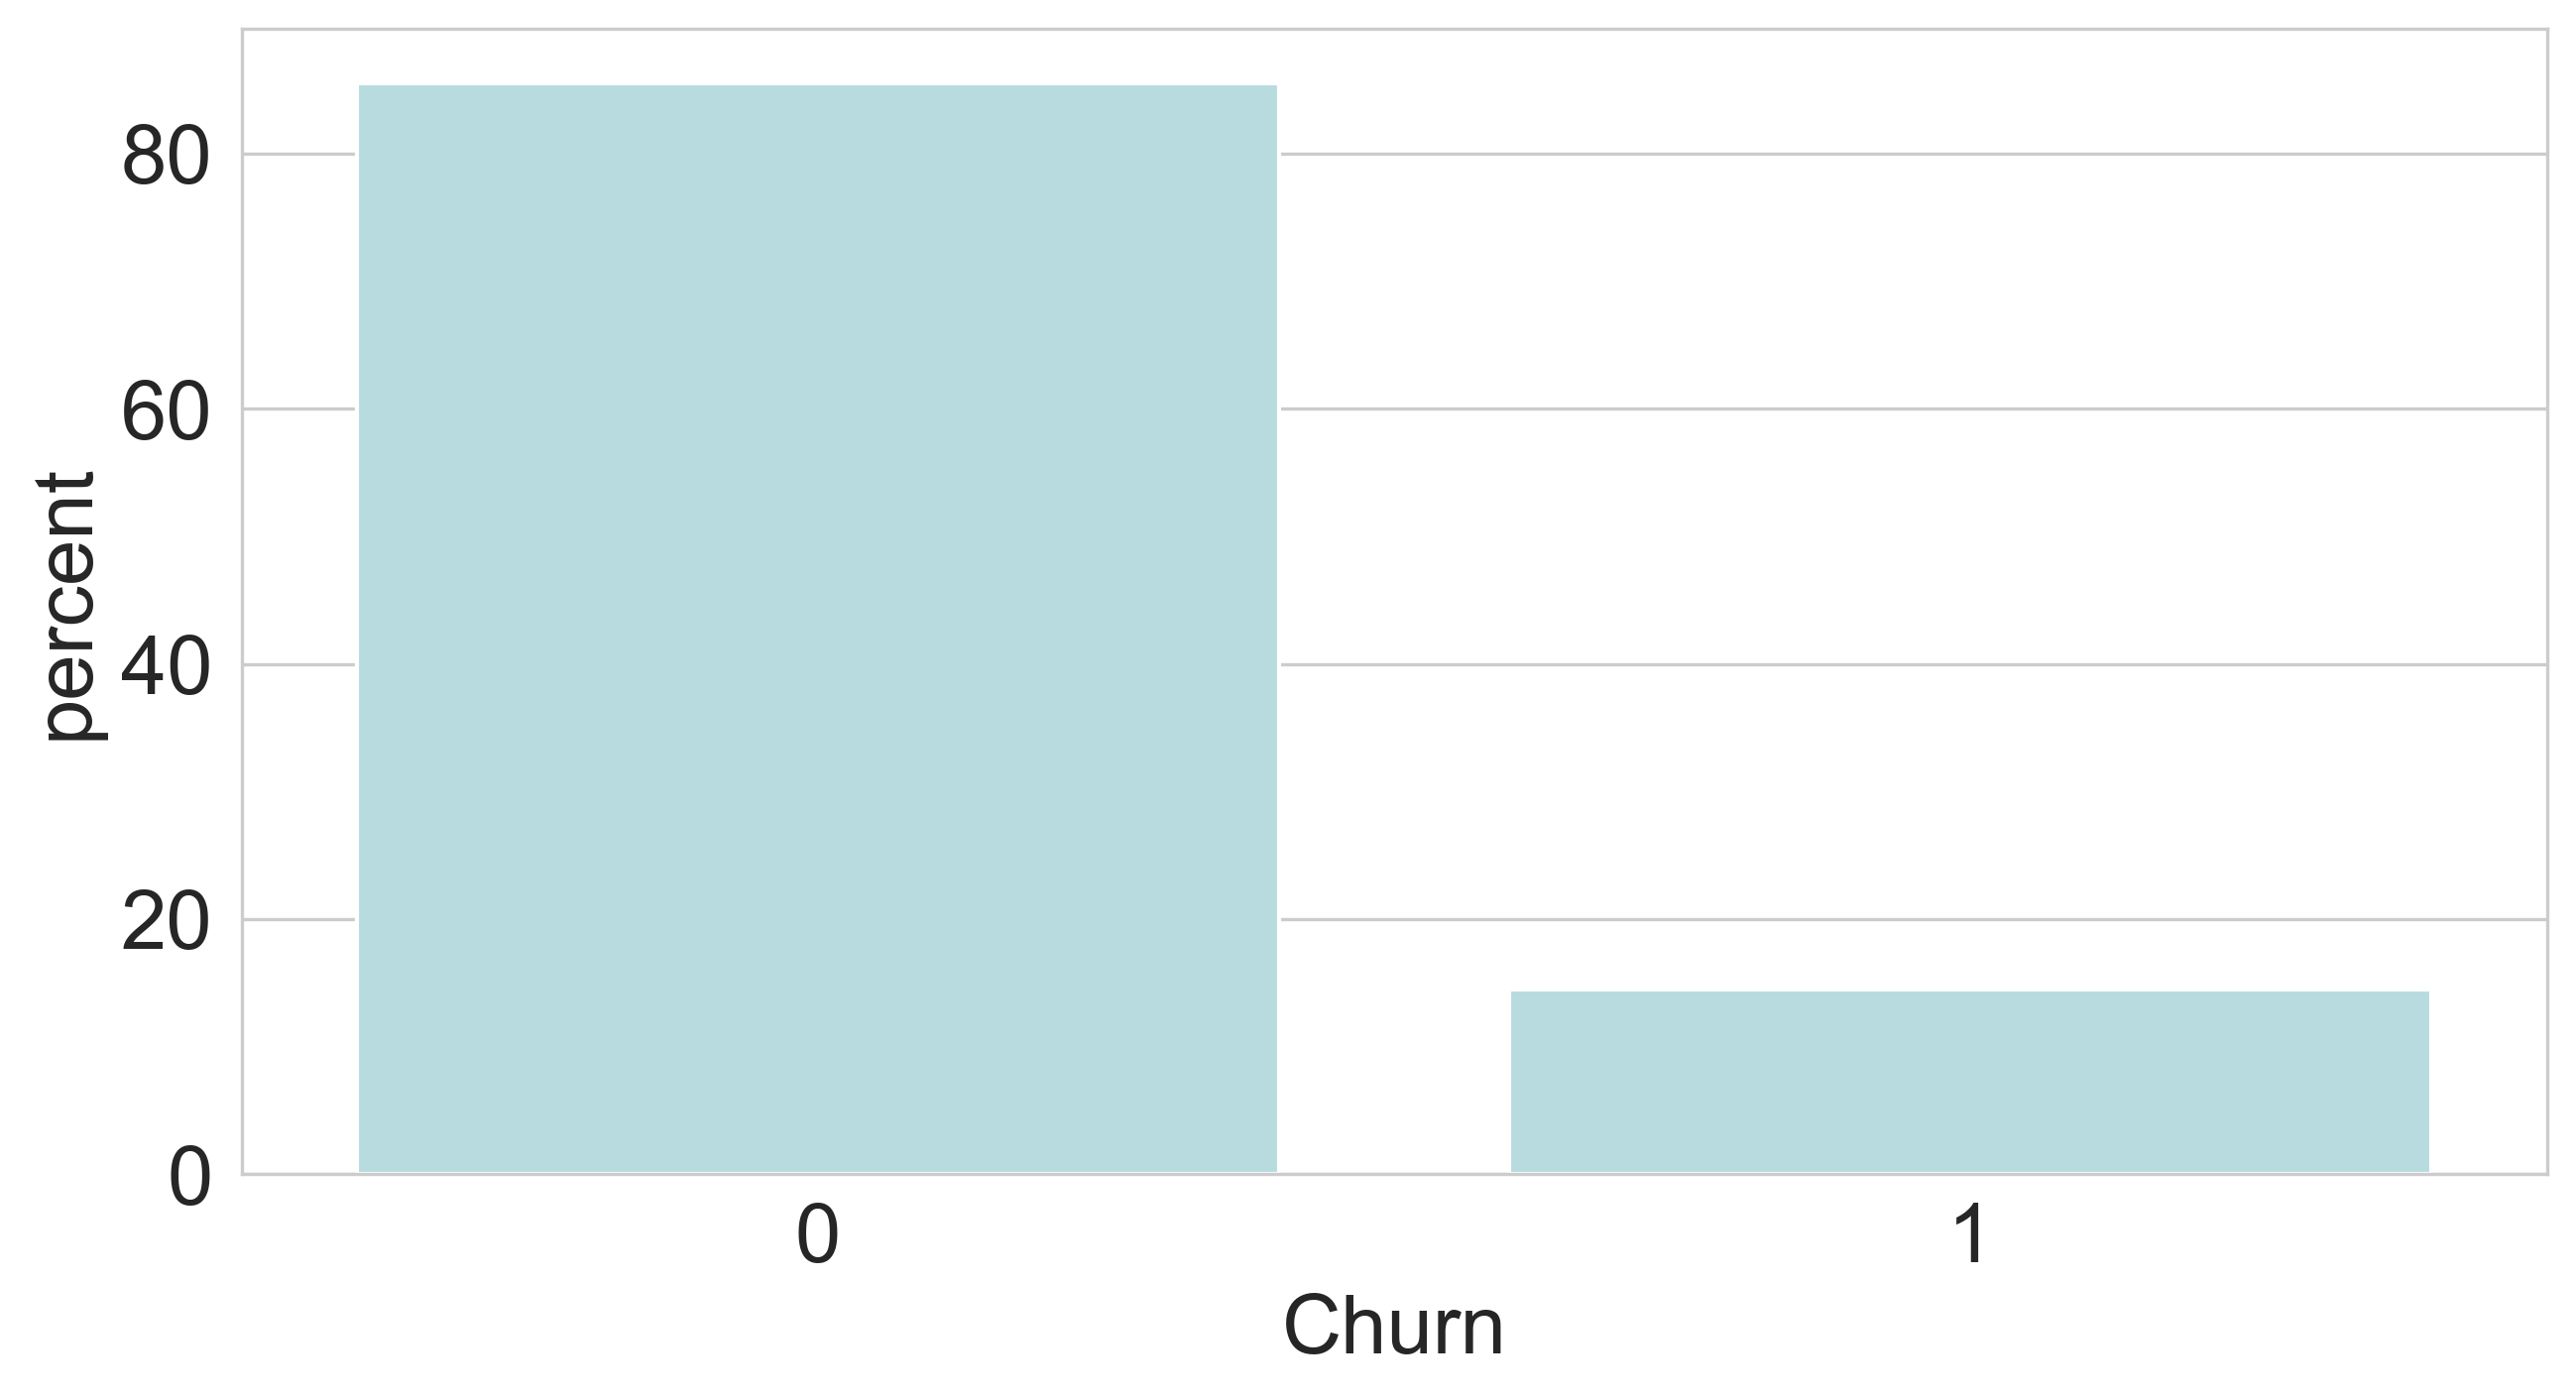

In [58]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.countplot(x=data["Churn"], stat = 'percent', color='powderblue')
plt.show()

Правильно закодируем значения в качественных переменных.

In [59]:
data.replace({'yes': 1, 'no': 0}, inplace=True)

Разделим переменные на качественные и количественные:

In [60]:
for col in data.columns:
    print(f'{col} has _{data[col].nunique()}_ unique values')

State has _51_ unique values
Account_Length has _212_ unique values
Area_Code has _3_ unique values
Phone has _3333_ unique values
Intl_Plan has _2_ unique values
VMail_Plan has _2_ unique values
VMail_Message has _46_ unique values
Day_Mins has _1667_ unique values
Day_Calls has _119_ unique values
Day_Charge has _1667_ unique values
Eve_Mins has _1611_ unique values
Eve_Calls has _123_ unique values
Eve_Charge has _1440_ unique values
Night_Mins has _1591_ unique values
Night_Calls has _120_ unique values
Night_Charge has _933_ unique values
Intl_Mins has _162_ unique values
Intl_Calls has _21_ unique values
Intl_Charge has _162_ unique values
CustServ_Calls has _10_ unique values
Churn has _2_ unique values


Удалим переменную Phone, потому что она содержит только уникальные значения.

In [61]:
data = data.drop(['Phone'], axis='columns') 

In [62]:
num_columns = []
qual_columns = []

for col in data.columns:
    if data[col].nunique() > 51:
        num_columns.append(col)
    else:
        qual_columns.append(col)

Посмотрим на баланс классов в качественных переменных:

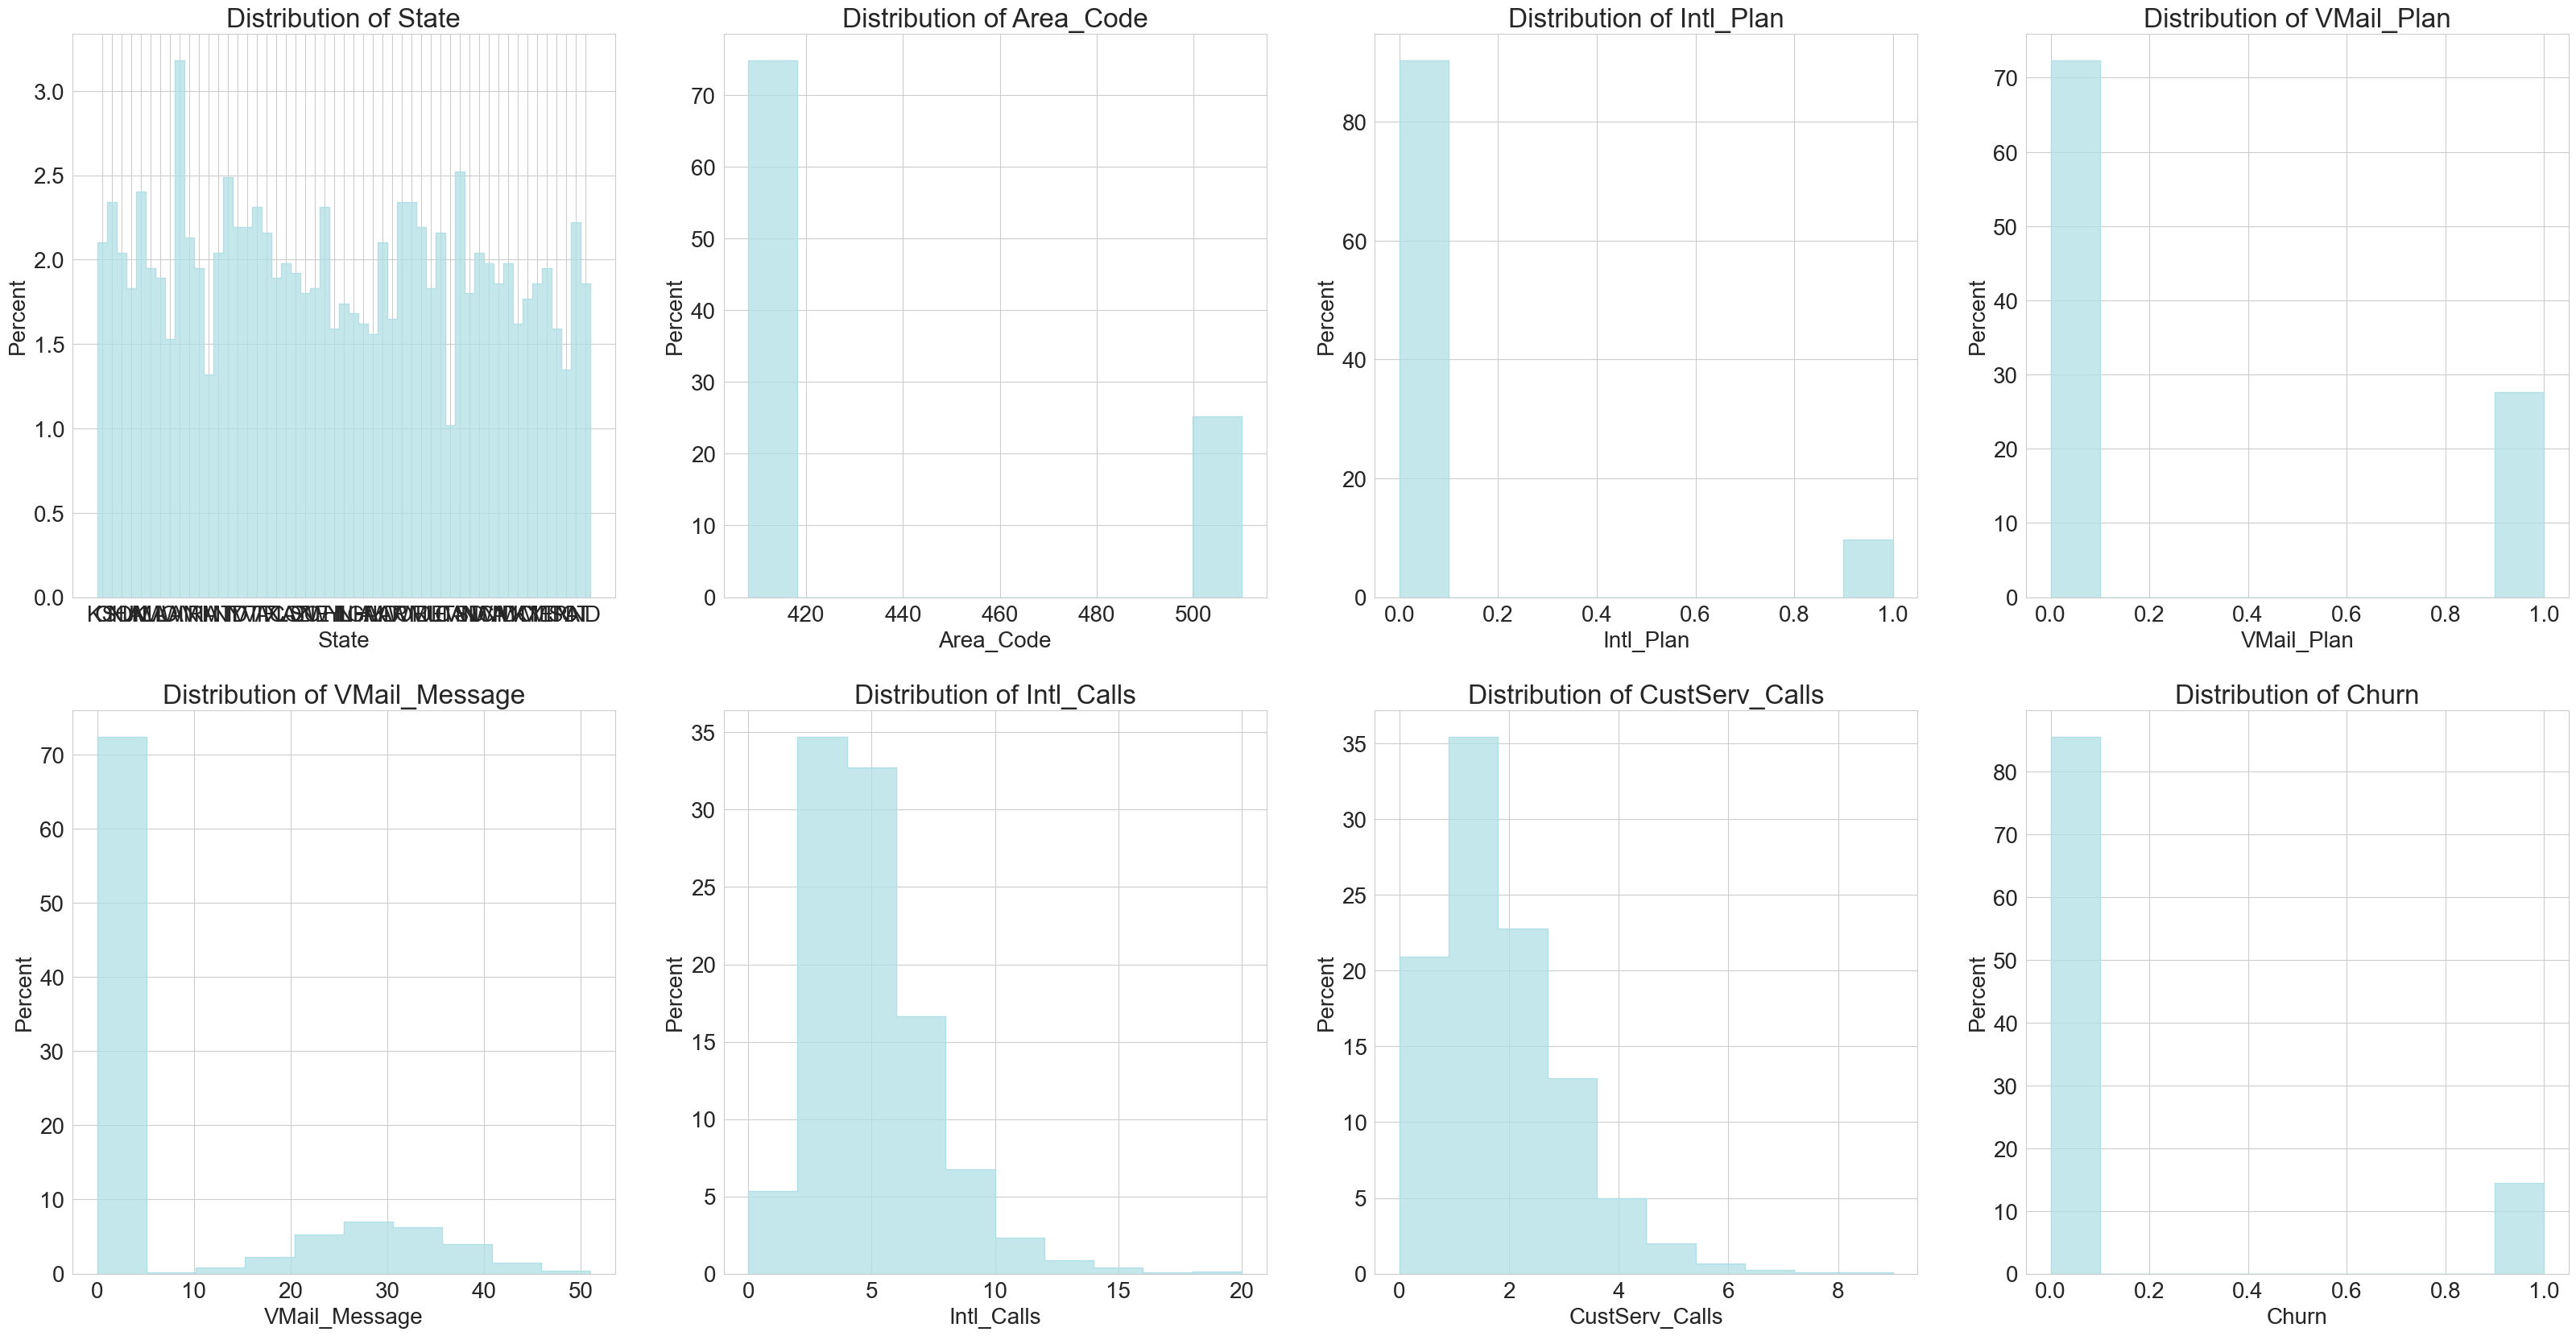

In [63]:
plt.figure(figsize=(40, 20))
for i, column in enumerate(qual_columns):
    plt.subplot(2, 4, i+1)
    sns.histplot(data[column], bins=10, element="step", stat = 'percent', color='powderblue')
    plt.title(f'Distribution of {column}')

Видим, что все классы, кроме относящихся к State, не сбалансированы, в State слишком много уникальных значений, удалим.

In [84]:
data = data.drop(['State'], axis='columns') 

Посмотрим распределение количественных признаков:

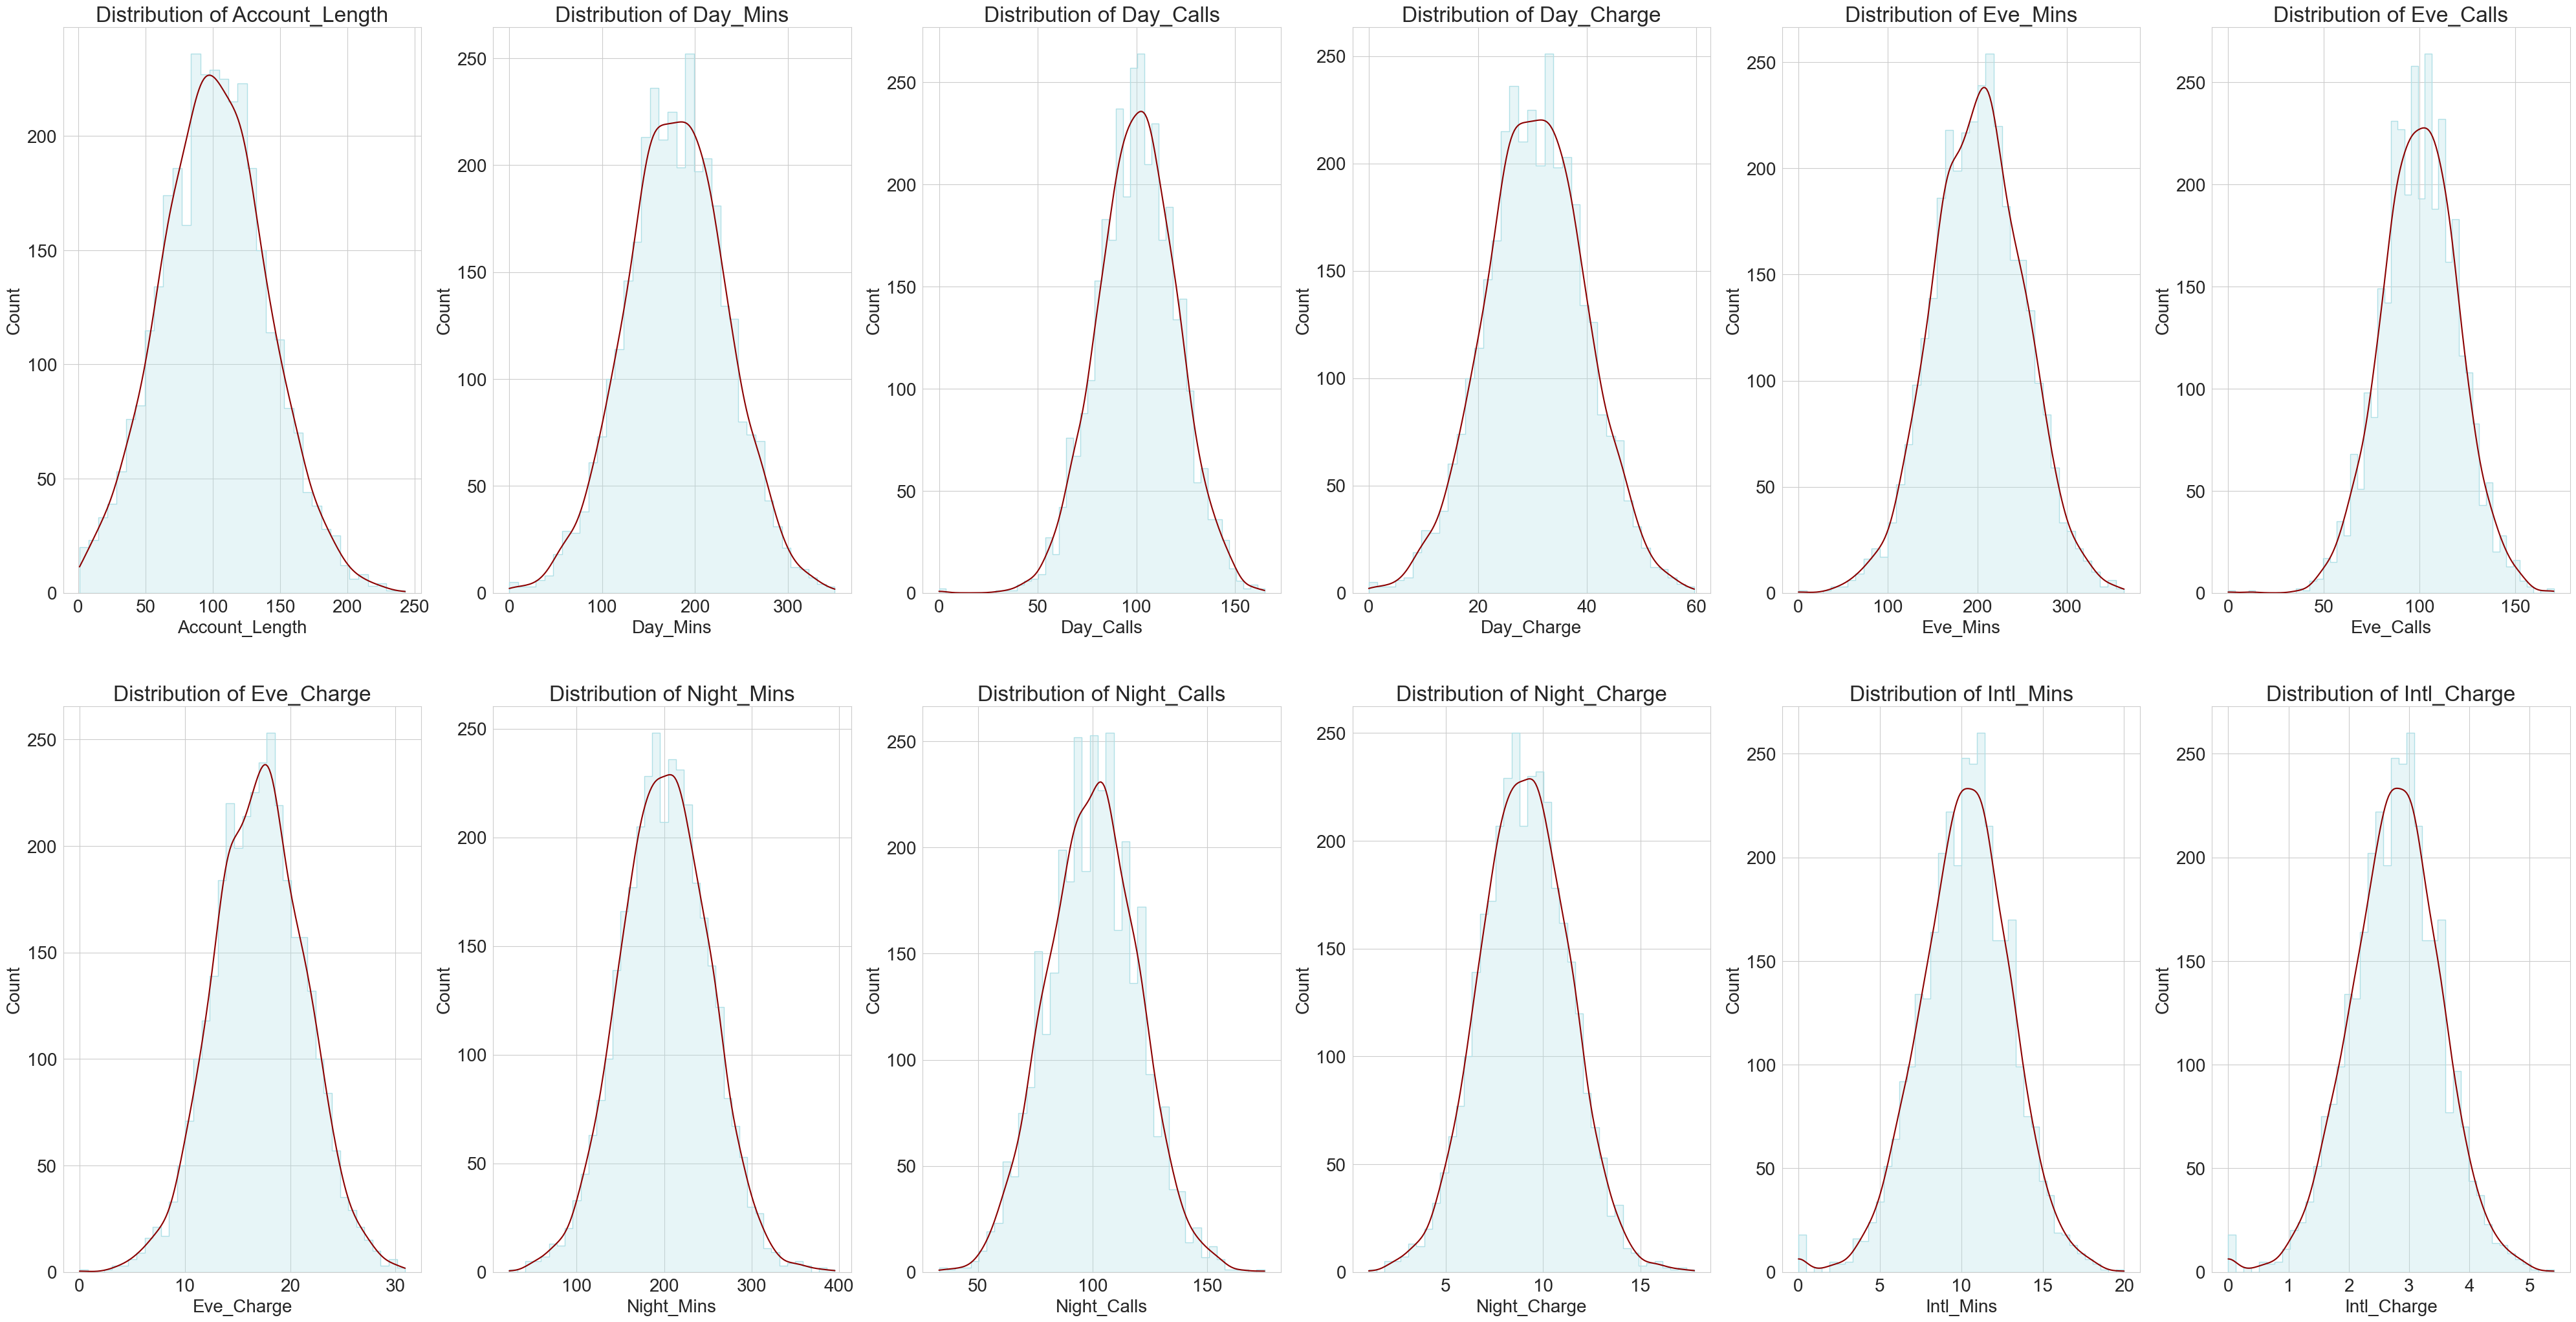

In [64]:
plt.figure(figsize=(50, 25))
for i, column in enumerate(num_columns):
    plt.subplot(2, 6, i+1)
    sns.histplot(data[column], color='powderblue',element="step", alpha=0.3, kde = True).lines[0].set_color('darkred')
    plt.title(f'Distribution of {column}')

Видим, что распределение значений большей части переменных совпадает.

Построим корреляционную матрицу для исследуемых признаков:

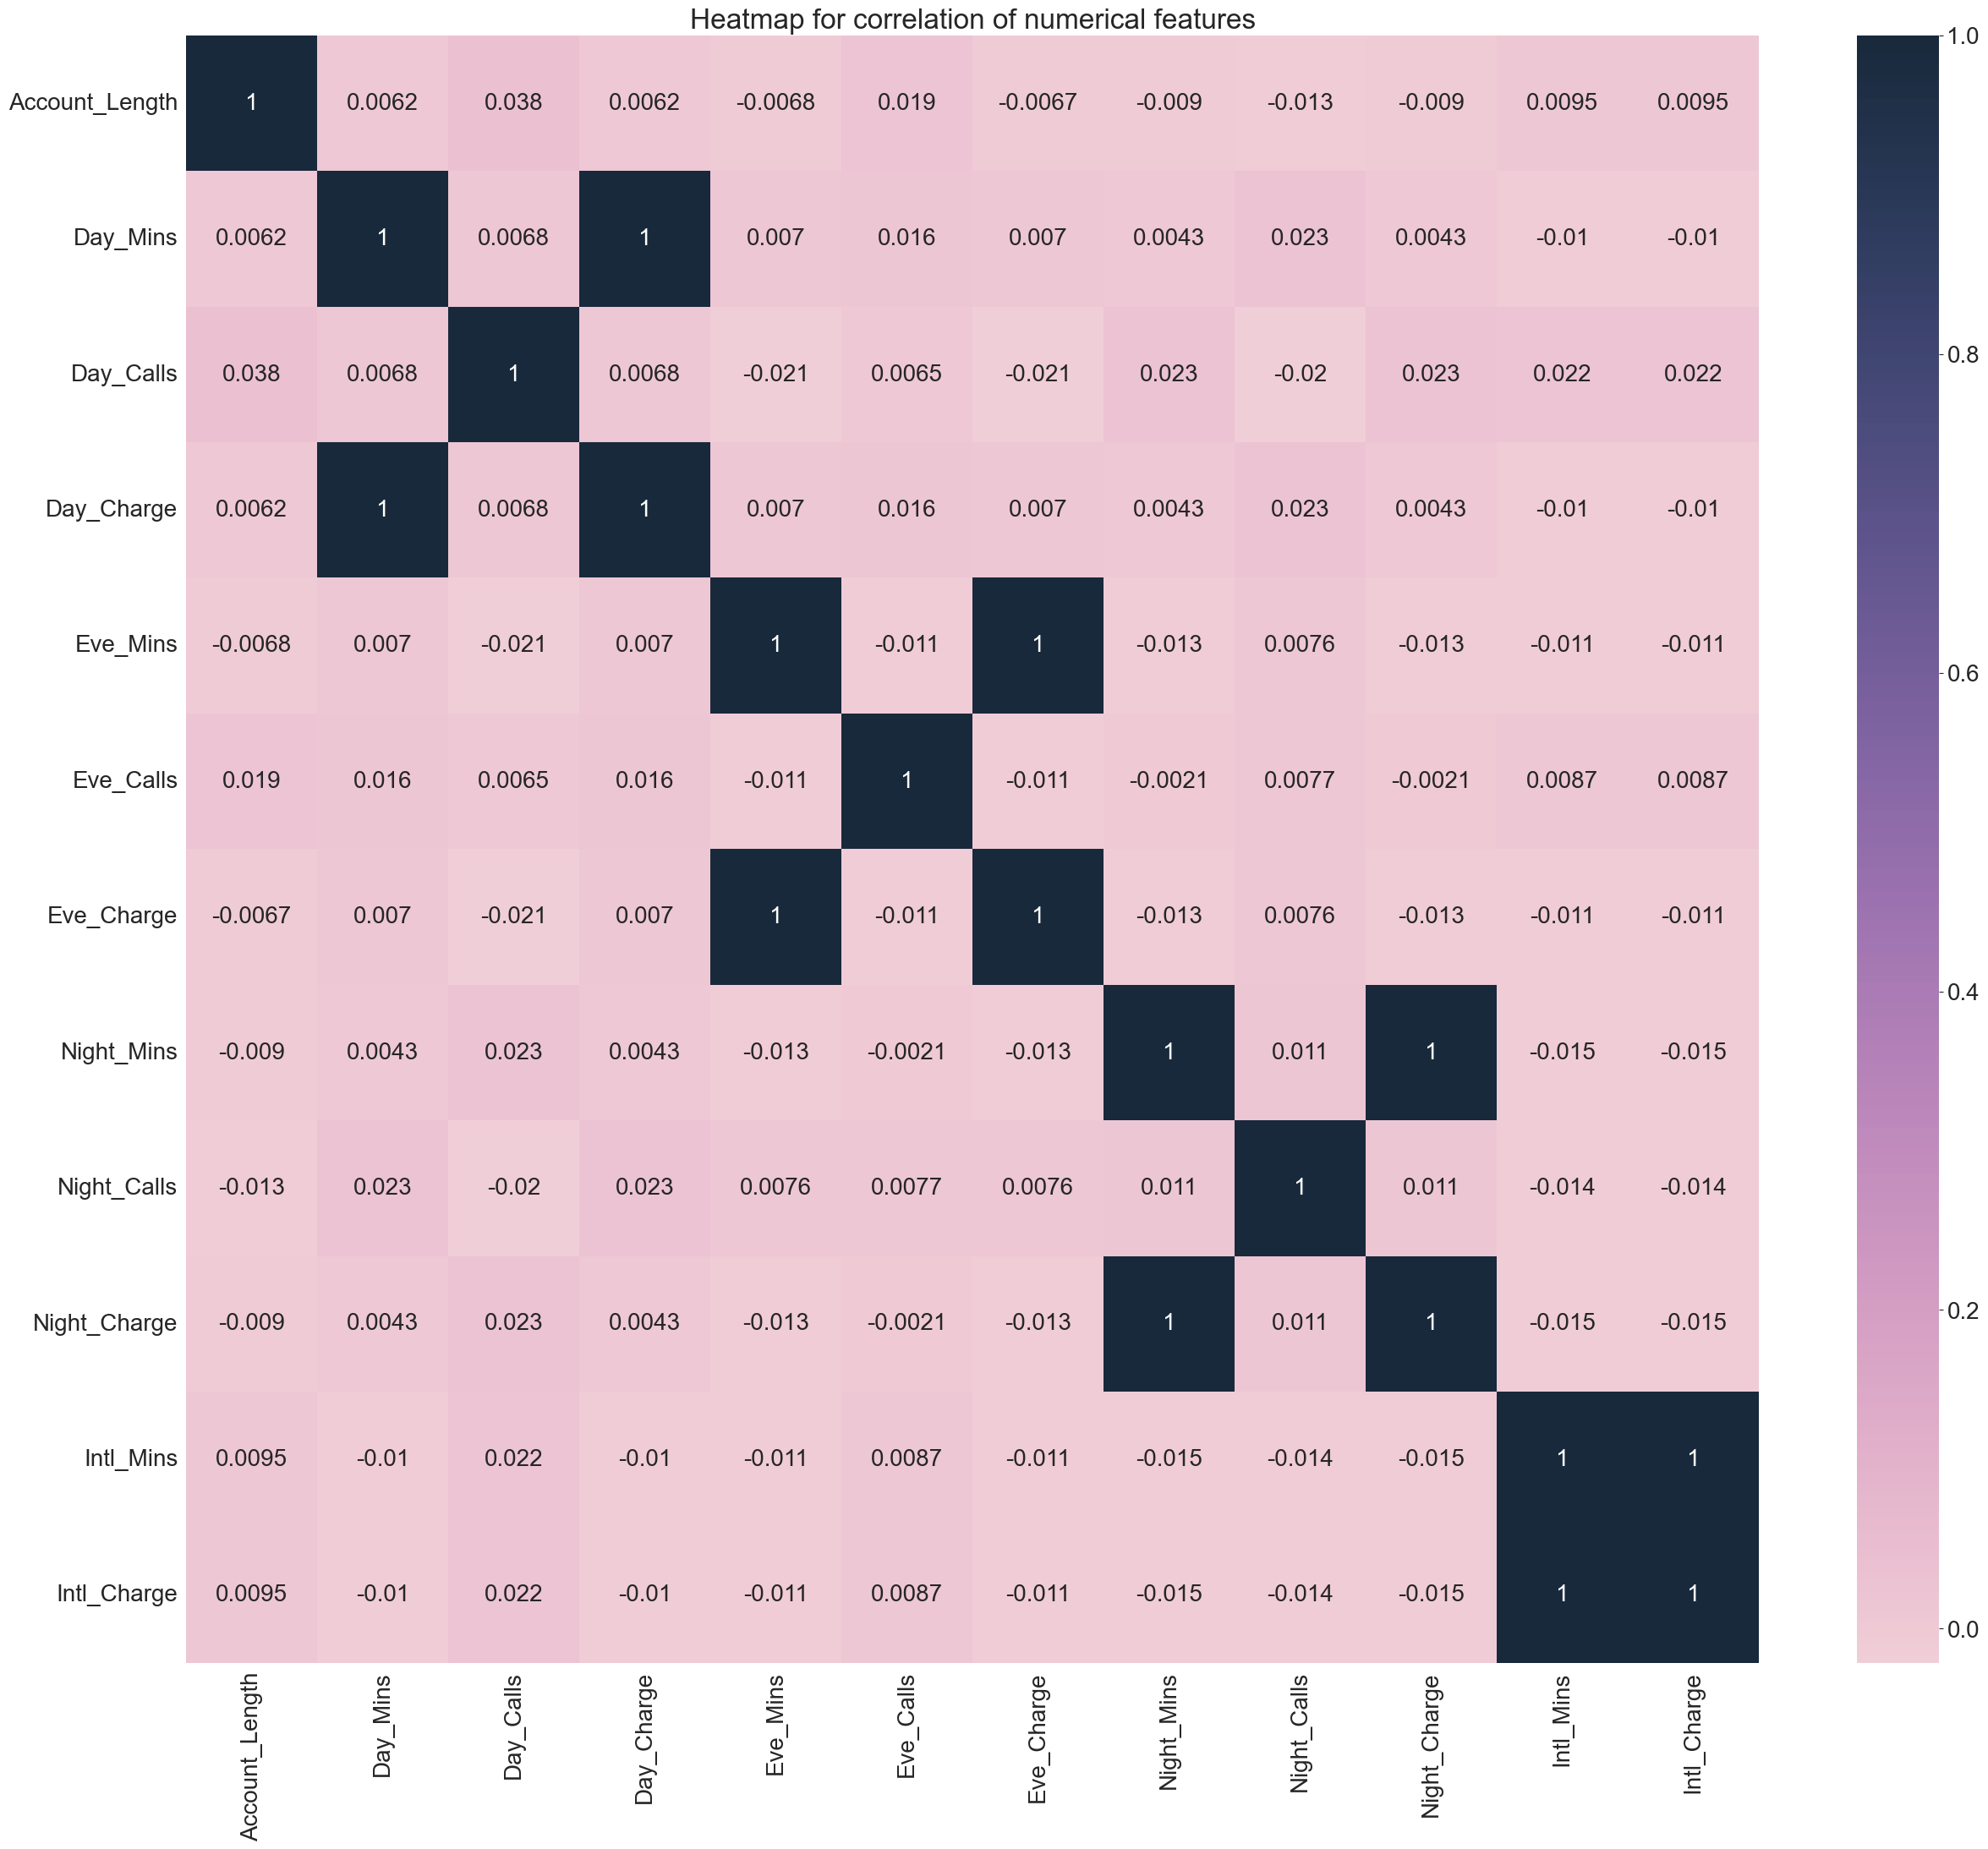

In [65]:
corr_matrix = data[num_columns].corr()

plt.figure(figsize=(30, 25))
cub = sns.cubehelix_palette(start=-.5, rot=.5, as_cmap=True)
sns.heatmap(corr_matrix, annot = True, cmap = cub)
plt.title('Heatmap for correlation of numerical features')
plt.show()

Видим, что _Charge и _Mins крайне сильно скоррелированы, поэтому выбросим все _Charge из исследования.

In [66]:
_charge_columns = []
for col in data.columns:
    if "_Charge" in col:
        _charge_columns.append(col)

In [67]:
_charge_columns

['Day_Charge', 'Eve_Charge', 'Night_Charge', 'Intl_Charge']

In [85]:
data_filt = data.drop(_charge_columns, axis=1)

In [86]:
data_filt.head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,Intl_Mins,Intl_Calls,CustServ_Calls,Churn
0,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


Можно приступить непосредственно к подбору моделей.

In [87]:
X = data_filt.drop(['Churn'], axis = 1)
y = data_filt['Churn']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=SEED)

In [89]:
xgb = xgboost.XGBRFClassifier(random_state=SEED, verbosity=0)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_ff = lightgbm.LGBMClassifier(boosting_type="rf")


In [90]:
params = {'max_depth': [1, 3, 6, 9], 'n_estimators': [20, 50, 101]}
val = KFold(n_splits=5, shuffle=True, random_state=SEED)

best_model_xgb = GridSearchCV(xgb, param_grid=params, cv=val)
best_model_xgb.fit(X_train, y_train)
y_pred = best_model_xgb.predict(X_test)

Узнаем, какие параметры модели показали себя лучше всего, и каким получился показатель accuracy:

In [92]:
print(best_model_xgb.best_estimator_)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=9, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=101, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...)


In [93]:
accuracy_score(y_test, y_pred)

0.9427272727272727

То же самое сделаем для lightgbm.LGBMClassifier:

In [95]:
params = {'max_depth': [1, 3, 6, 9, 12], 'n_estimators': [20, 50, 101, 151]}
val = KFold(n_splits=5, shuffle=True, random_state=SEED)

best_model_lgbm = GridSearchCV(lgbm, param_grid=params, cv=val)
best_model_lgbm.fit(X_train, y_train)
y_pred = best_model_lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 257, number of negative: 1529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143897 -> initscore=-1.783293
[LightGBM] [Info] Start training from score -1.783293
[LightGBM] [Info] Number of positive: 264, number of negative: 1522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147816 -> initscore=-1.751831
[LightGBM] [Info] Start training from score -1.751831
[LightGBM] [Info] Nu

In [96]:
print(best_model_lgbm.best_estimator_)

LGBMClassifier(max_depth=9, n_estimators=101, random_state=111)


In [97]:
accuracy_score(y_test, y_pred)

0.9518181818181818

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

Студент не рисователь, поэтому прикрепляет мем, нарисованный в паинте

![pain.png](https://sun9-76.userapi.com/impg/nwPwoY5EMS7eHrPHmUXe6A4OxB2k_MF6YWnuqw/E9M-v-aX2kI.jpg?size=932x1080&quality=95&sign=3462c182ed71dca2198221d78c06ed80&type=album)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**